In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as snx
import plotly.express as px

from category_encoders import MEstimateEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv


In [2]:
df = pd.read_csv('/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv')
df_car = df.copy()

df_car

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


### Data Observation, Cleaning

In [3]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [4]:
# Replace '-' into 0 and change datatype into numerical

df_car['Levy'] = df_car['Levy'].replace('-', '0').astype(int)

In [5]:
df_car['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [6]:
# Remove 'Turbo' into  and change datatype into numerical

df_car['Engine volume'] = df_car['Engine volume'].str.replace(' Turbo', '').astype(float)

In [7]:
# Remove 'km'  and change datatype into numerical

df_car['Mileage'] = df_car['Mileage'].str.replace(' km', '').astype(int)

In [8]:
df_car['Doors'].value_counts()

Doors
04-May    18332
02-Mar      777
>5          128
Name: count, dtype: int64

In [9]:
# Remove '-May', '-Mar', '>' and change dataype into numerical

df_car['Doors'] = df_car['Doors'].str.replace('-May', '').str.replace('-Mar', '').str.replace('>', '').astype(int)

In [10]:
df_car.describe()

,ID,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Doors,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,632.528669,2010.912824,2.307990,1.532236e+06,4.582991,3.925872,6.582627
std,9.365914e+05,1.905813e+05,567.721688,5.668673,0.877805,4.840387e+07,1.199933,0.403399,4.320168
min,2.074688e+07,1.000000e+00,0.000000,1939.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000
25%,4.569837e+07,5.331000e+03,0.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,642.000000,2012.000000,2.000000,1.260000e+05,4.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,5.000000,16.000000


In [11]:
# Check null values

df_car.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [12]:
# Check duplicated values

df_car.duplicated().sum()

313

In [13]:
df_car.drop_duplicates(inplace = True)

In [14]:
df_car.duplicated().sum()

0

In [15]:
category_counts = df_car['Category'].value_counts()
for category, count in category_counts.items():
    print(f"{category}: {count}")

Sedan: 8600
Jeep: 5378
Hatchback: 2799
Minivan: 633
Coupe: 528
Universal: 361
Microbus: 299
Goods wagon: 229
Pickup: 51
Cabriolet: 35
Limousine: 11


#### Data Validation

In [16]:
df_car

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8
2,45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4.0,Manual,Rear,2,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4.0,Tiptronic,Front,4,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4.0,Automatic,Front,4,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4.0,Automatic,Front,4,Left wheel,Black,4


In [17]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  int64  
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  float64
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  int64  
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object 
 17

### EDA

In [18]:
df_index = df_car.copy()
df_index['Index'] = range(len(df_index))

fig = px.scatter(df_index, 
                 x='Price', 
                 y='Index', 
                 title='Car Price Distribution')

fig.update_traces(marker=dict(color='teal'))
fig.update_layout(xaxis_type='log', width=1200, height=600)

fig.show()

In [19]:
top10_categories = df_car['Category'].value_counts().sort_values(ascending=False).head(10)

top10_df = top10_categories.reset_index()
top10_df.columns = ['Category', 'count']

# B Chart
fig = px.bar(top10_df, 
             x='Category', 
             y='count', 
             title='Top 10 Car Categories',
             labels={'category': 'Category', 'count': 'Count'})
fig.update_traces(marker= dict(color = '#ADD8E6'))
fig.update_layout(width = 1200, height = 600)

fig.show()

In [20]:
top10_Manufacturers = df_car['Manufacturer'].value_counts().sort_values(ascending=False).head(10)

top10_df = top10_Manufacturers	.reset_index()
top10_df.columns = ['Manufacturer', 'count']

# B Chart
fig = px.bar(top10_df, 
             x='Manufacturer', 
             y='count', 
             title='Top 10 Car Brands',
             labels={'manufacturer': 'Manufacturer', 'count': 'Count'})
fig.update_traces(marker= dict(color= 'teal'))
fig.update_layout(width = 1200, height = 600)

fig.show()

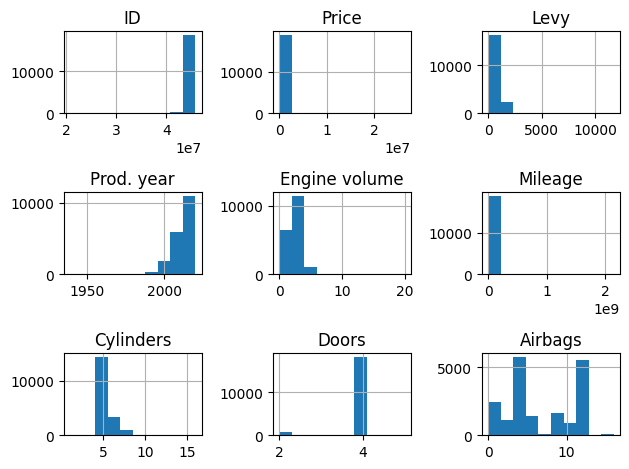

In [21]:
df_car.hist()
plt.tight_layout()

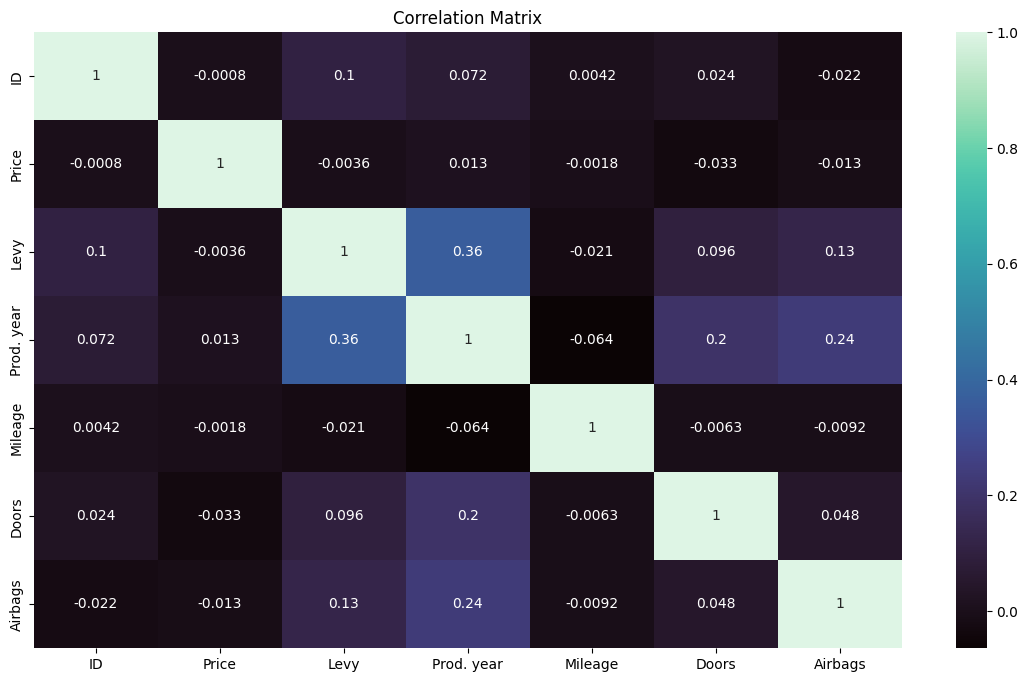

In [22]:
numeric_cols = df_car.select_dtypes('int64', 'float64')
corr_matrix = numeric_cols.corr()

plt.figure(figsize =(14, 8))
snx.heatmap(corr_matrix, annot = True, cmap ='mako')
plt.title('Correlation Matrix')
plt.show()

### Data Preprocessing

In [23]:
# Interquartile Range (IQR) to remove outliers

data_numeric = df_car.select_dtypes(exclude='object')

for col in data_numeric.columns:
    q1 = data_numeric[col].quantile(0.25)
    q3 = data_numeric[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - (1.5 * iqr)
    high = q3 + (1.5 * iqr)
    
    #count outliers
    outliers = ((data_numeric[col]> high) | (data_numeric[col] < low)).sum()
    total = data_numeric.shape[0]
    print (f"Total Outliers in {col} are: {outliers} - {round(100 * (outliers / total), 2)}%")
    
    # filter data remove outliers
    if outliers > 0:
        df_car = df_car.loc[(df_car[col] <= high) & (df_car[col]>= low)]

Total Outliers in ID are: 2460 - 13.0%
Total Outliers in Price are: 1055 - 5.57%
Total Outliers in Levy are: 160 - 0.85%
Total Outliers in Prod. year are: 962 - 5.08%
Total Outliers in Engine volume are: 1358 - 7.18%
Total Outliers in Mileage are: 635 - 3.36%
Total Outliers in Cylinders are: 4765 - 25.18%
Total Outliers in Doors are: 892 - 4.71%
Total Outliers in Airbags are: 0 - 0.0%


In [24]:
df_train = df_car.drop(['ID',], axis = 1)
df_train

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4
5,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2.0,160931,4.0,Automatic,Front,4,Left wheel,White,4
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909,4.0,Automatic,Front,4,Left wheel,White,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,470,645,TOYOTA,Prius,2011,Hatchback,Yes,Hybrid,1.8,307325,4.0,Automatic,Front,4,Left wheel,Silver,12
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4.0,Tiptronic,Front,4,Left wheel,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4.0,Automatic,Front,4,Left wheel,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4.0,Automatic,Front,4,Left wheel,Black,4


In [25]:
x = df_train.drop('Price', axis = 1)
y = df_train['Price']

In [26]:
object_cols = df_train.select_dtypes(include = ['object']).columns.tolist()

MEncoder = MEstimateEncoder(cols = object_cols, m = 0.5)
x = MEncoder.fit_transform(x, y)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [28]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test =  scaler.fit_transform(x_test)

1. IQR
2. create df_train and dropping of columns
3. splitting x, y
4. Encoder (MEstimateEncoder)
5. train_test_split
6. scaler (RobustScaler)

In [29]:
df_car.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2.0,160931,4.0,Automatic,Front,4,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909,4.0,Automatic,Front,4,Left wheel,White,12


### Data Modelling and Prediction
#### Linear Regression

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [31]:
lr_pred = lr.predict(x_test)
lr_plot = pd.DataFrame({'Actual Values': y_test, 'Predicted Values': lr_pred})

lr_plot.head()

,Actual Values,Predicted Values
17155,14740,9746.266070
2189,188,10072.431513
4108,19757,22487.525920
11530,941,13295.507238
188,7840,14464.940689


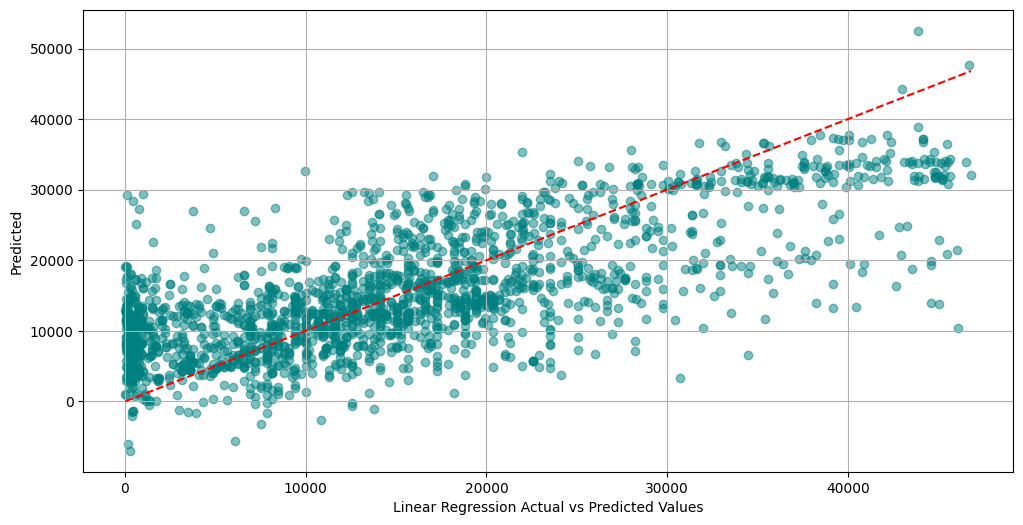

In [32]:
plt.figure(figsize=(12,6))
plt.scatter(y_test, lr_pred, color = 'teal', alpha = 0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], color = 'red', linestyle ='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlabel('Linear Regression Actual vs Predicted Values')
plt.grid()

In [33]:
lr_r2 = r2_score(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

### Random Forest

In [34]:
pipeline = Pipeline([
('scaler', RobustScaler()),
('rf', RandomForestRegressor(random_state=42))
])

In [35]:
param_grid = {
'rf__n_estimators': [100, 200, 300],
'rf__max_depth': [None, 10, 20, 30],
'rf__min_samples_split': [2, 5, 10],
'rf__min_samples_leaf': [1, 2, 4]
}

In [36]:
grid_search = GridSearchCV(estimator=pipeline,
param_grid=param_grid,
cv=2, n_jobs=-1,
verbose=2)

In [37]:
grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   5.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=   2.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time=   5.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=100; total time=   2.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time=   4.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=   2.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200; total time=   4.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100; to

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20, 30],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             verbose=2)

In [38]:
best_params = grid_search.best_params_
print('Best parameters:',best_params)

Best parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [50]:
rf_pred = grid_search.best_estimator_.predict(x_test)
rf_plot = pd.DataFrame({'Actual Values': y_test, 'Predicted Values': fr_pred})

rf_plot.head()

,Actual Values,Predicted Values
17155,14740,13175.084971
2189,188,937.557339
4108,19757,19364.183333
11530,941,4294.233523
188,7840,8759.732272


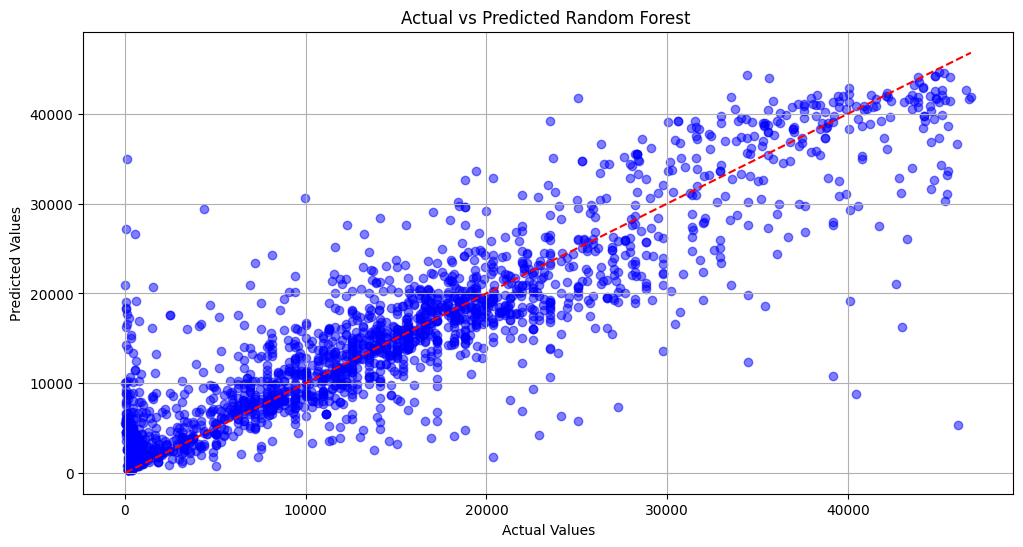

In [51]:
plt.figure(figsize = (12, 6))
plt.scatter(y_test, rf_pred, color = 'blue', alpha = 0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], color = 'red', linestyle = '--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Random Forest ')
plt.grid()

In [52]:
rf_r2 = r2_score(y_test, fr_pred)
rf_mse = mean_squared_error(y_test, fr_pred)
rf_mae = mean_absolute_error(y_test, fr_pred)

### XGBoost

In [41]:
xg_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [42]:
param_grid = {
    'model__learning_rate': [0.05, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    'model__n_estimators': [100, 200, 300, 500],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5]
}

In [43]:
xg_grid_search = GridSearchCV(estimator=xg_pipeline, 
                              param_grid=param_grid, 
                              cv=2, 
                              scoring='neg_mean_squared_error',
                              verbose=2,
                              n_jobs=-1)

In [44]:
xg_grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   5.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=   2.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time=   5.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=100; total time=   2.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=10, rf__n_estimators=200; total time=   4.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=   2.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=200; total time=   4.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=100; 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=Non...
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1, 0.3],
                         'model__max_depth': [3, 5, 7, 10],
                         'model__n_estimators': [100, 200, 300, 500],
                         'model__reg_alpha': [0, 0.1, 0.5],
                         'model__reg_lambda': [0, 0.1, 0.5],
                         'model__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [45]:
best_params = xg_grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__reg_alpha': 0.5, 'model__reg_lambda': 0, 'model__subsample': 0.8}


In [46]:
xg_pred = xg_grid_search.predict(x_test)

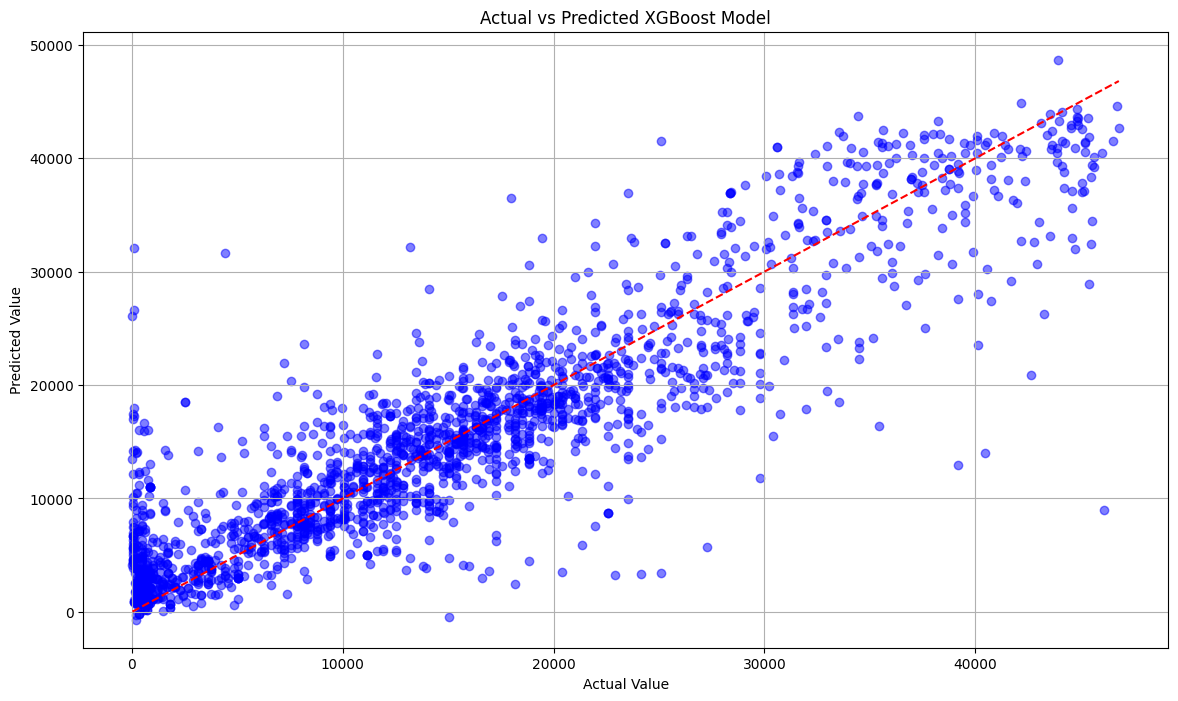

In [53]:
plt.figure(figsize=(14,8))
plt.scatter(y_test, xg_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted XGBoost Model')
plt.grid(True)
plt.show()

In [47]:
xg_r2 = r2_score(y_test, xg_pred)
xg_mse = mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)

R^2: 0.8114536555845027
MSE: 25113556.094323285
MAE: 3436.9073855082192
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.3, model__max_depth=10, model__n_estimators=200, model__reg_alpha=0.5, model__reg_lambda=0, model__subsample=0.8; total time=   1.9s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.3, model__max_depth=10, model__n_estimators=200, model__reg_alpha=0.5, model__reg_lambda=0.1, model__subsample=0.8; total time=   1.9s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.3, model__max_depth=10, model__n_estimators=200, model__reg_alpha=0.5, model__reg_lambda=0.5, model__subsample=0.8; total time=   1.9s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.3, model__max_depth=10, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=0, model__subsample=0.8; total time=   2.8s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.3, model__max_depth=10, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=0.

### Model Evaluation

In [54]:
models = ['Linear Regression','Random Forest', 'XGBoost']
data = [[lr_r2,lr_mse, lr_mae],[rf_r2, rf_mse, rf_mae], [xg_r2, xg_mse, xg_mae]]
cols = ['R2','MSE','MAE']
pd.DataFrame(data, columns = cols, index = models).sort_values(ascending = False, by ='R2')

,R2,MSE,MAE
XGBoost,0.811454,2.511356e+07,3436.907386
Random Forest,0.805536,2.590182e+07,3329.539499
Linear Regression,0.538402,6.148291e+07,6070.440931
